# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, gc, re, joblib
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize as cnorm
import anndata
import scanpy as sc
import sctk as sk
#import bbknn
import phate

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = sk.expression_colormap()

In [2]:
sk.set_figsize((4, 4))

In [3]:
import seaborn as sn

In [4]:
import numpy_groupies as npg

In [5]:
import plotnine as pln
from plotnine import ggplot, aes

In [6]:
def load_de_genes(fn, sep=',', max_p=0.01, min_lfc=2, max_n=1000):
    de_df = pd.read_csv(fn, sep=sep, index_col=0)
    de_df = de_df.where(lambda x: (x.padj < max_p) & (x.log2FoldChange > np.log2(min_lfc))).dropna().sort_values(['padj', 'log2FoldChange'], ascending=[True, False])
    return de_df.iloc[0:max_n, :]

In [7]:
def load_de_peaks(fn, sep=',', max_p=0.01, min_lfc=2, max_n=1000, peak_types=[]):
    de_df = pd.read_csv(fn, sep=sep, index_col=0)
    de_df = de_df.where(lambda x: (x.padj < max_p) & (x.log2FoldChange > np.log2(min_lfc))).dropna().sort_values(['padj', 'log2FoldChange'], ascending=[True, False])
    if peak_types:
        k = pd.Series(de_df.index).str.rpartition(',')[2].isin(peak_types).values
        de_df = de_df.loc[k]
    return de_df.iloc[0:max_n, :]

# Load data

## RNA

In [8]:
!ls bulkRNA_DE/*.csv

bulkRNA_DE/IFNA_over_unstim.csv   bulkRNA_DE/IL6_over_unstim.csv
bulkRNA_DE/IFNG_over_unstim.csv   bulkRNA_DE/metadata.csv
bulkRNA_DE/IL13_over_unstim.csv   bulkRNA_DE/OSM_over_unstim.csv
bulkRNA_DE/IL17A_over_unstim.csv  bulkRNA_DE/TGFB1_over_unstim.csv
bulkRNA_DE/IL1B_over_unstim.csv   bulkRNA_DE/TNF_over_unstim.csv
bulkRNA_DE/IL22_over_unstim.csv


In [9]:
rna_stimulations = !ls bulkRNA_DE/ | grep 'unstim.csv$' | cut -f1 -d'_'

In [10]:
rna_up_genes = {rstim: load_de_genes(f'bulkRNA_DE/{rstim}_over_unstim.csv', sep=',', max_p=0.05, min_lfc=1.5) for rstim in rna_stimulations}

In [11]:
{k: len(v) for k,v in rna_up_genes.items()}

{'IFNA': 403,
 'IFNG': 473,
 'IL13': 116,
 'IL17A': 48,
 'IL1B': 253,
 'IL22': 47,
 'IL6': 1,
 'OSM': 119,
 'TGFB1': 231,
 'TNF': 405}

In [12]:
#rna_ad = sc.read('scRNA_batch1_2.processed.h5ad')
rna_ad = sc.read('../data/rna/scRNA_batch1_2.processed.fibroblasts.h5ad')

Only considering the two last: ['.fibroblasts', '.h5ad'].
Only considering the two last: ['.fibroblasts', '.h5ad'].


In [13]:
rna_ad = anndata.AnnData(rna_ad.raw.X, obs=rna_ad.obs.copy(), var=rna_ad.raw.var.copy(), obsm=rna_ad.obsm.copy())

In [14]:
rna_ad

AnnData object with n_obs × n_vars = 26727 × 17592
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'

## ATAC

In [15]:
!ls bulkATAC_DE/*.txt

bulkATAC_DE/IFNa.IFNa-vs-unstimulated.txt
bulkATAC_DE/IFNg.IFNg-vs-unstimulated.txt
bulkATAC_DE/IL13.IL13-vs-unstimulated.txt
bulkATAC_DE/IL17A.IL17A-vs-unstimulated.txt
bulkATAC_DE/IL17A_IL22.IL17A_IL22-vs-unstimulated.txt
bulkATAC_DE/IL1B.IL1B-vs-unstimulated.txt
bulkATAC_DE/IL22.IL22-vs-unstimulated.txt
bulkATAC_DE/IL6.IL6-vs-unstimulated.txt
bulkATAC_DE/OSM.OSM-vs-unstimulated.txt
bulkATAC_DE/TGFb1.TGFb1-vs-unstimulated.txt
bulkATAC_DE/TNFa_IL13.TNFa_IL13-vs-unstimulated.txt
bulkATAC_DE/TNFa_IL17A.TNFa_IL17A-vs-unstimulated.txt
bulkATAC_DE/TNFa_OSM.TNFa_OSM-vs-unstimulated.txt
bulkATAC_DE/TNFa_TGFb1.TNFa_TGFb1-vs-unstimulated.txt
bulkATAC_DE/TNFa.TNFa-vs-unstimulated.txt
bulkATAC_DE/TNF_IFNg_IL17A.TNF_IFNg_IL17A-vs-unstimulated.txt
bulkATAC_DE/TNF_IFNg.TNF_IFNg-vs-unstimulated.txt


In [16]:
atac_stimulations = !ls bulkATAC_DE/ | grep 'unstimulated.txt$' | cut -f1 -d'.'

In [17]:
atac_up_all_peaks = {astim.upper(): load_de_peaks(f'bulkATAC_DE/{astim}.{astim}-vs-unstimulated.txt', sep='\t', max_p=0.01, min_lfc=2) for astim in atac_stimulations}

In [18]:
{k: len(v) for k,v in atac_up_all_peaks.items()}

{'IFNA': 430,
 'IFNG': 1000,
 'IL13': 605,
 'IL17A': 19,
 'IL17A_IL22': 43,
 'IL1B': 1000,
 'IL22': 1,
 'IL6': 1,
 'OSM': 1000,
 'TGFB1': 1000,
 'TNFA_IL13': 1000,
 'TNFA_IL17A': 1000,
 'TNFA_OSM': 1000,
 'TNFA_TGFB1': 1000,
 'TNFA': 1000,
 'TNF_IFNG_IL17A': 1000,
 'TNF_IFNG': 1000}

In [19]:
for astim in atac_stimulations:
    atac_up_all_peaks[astim.upper()]['stim'] = astim.upper()
    atac_up_all_peaks[astim.upper()]['rank'] = np.arange(atac_up_all_peaks[astim.upper()].shape[0])
    atac_up_all_peaks[astim.upper()]['peak_type'] = pd.Series(atac_up_all_peaks[astim.upper()].index).str.rpartition(',')[2].values

In [20]:
atac_up_all_peaks_df = pd.concat(list(atac_up_all_peaks.values()))

In [21]:
atac_up_all_peaks_df

baseMean  log2FoldChange  \
chr12:112978182-112978682,OAS2,Promoter  5613.686509        3.201410   
chr19:17405416-17405916,BST2,Promoter    3253.271244        3.549434   
chr8:143026243-143026743,LY6E-DT,Distal  6298.065003        2.119271   
chr10:89310018-89310518,IFIT2,Intronic   1901.074831        3.711045   
chr21:41425999-41426499,MX1,Exonic       3732.942210        2.446378   
...                                              ...             ...   
chr17:1607310-1607810,SLC43A2,Intronic   3693.431450        3.291578   
chr14:95480061-95480561,SYNE3,Distal     3395.646422        1.813475   
chr16:65002144-65002644,CDH11,Intronic   2273.143369        2.523923   
chr7:104973796-104974296,KMT2E,Distal    2738.729140        1.586547   
chr4:176902870-176903370,VEGFC,Distal    3684.282429        1.968632   

                                            lfcSE       stat        pvalue  \
chr12:112978182-112978682,OAS2,Promoter  0.167094  19.159347  8.088135e-82   
chr19:17405416-17405916,BST2,Promoter    0.194233  18.274109  1.330462e-74   
chr8:143026243-143026743,LY6E-DT,Distal  0.118489  17.885747  1.522983e-71   
chr10:89310018-89310518,IFIT2,Intronic   0.238221  15.578133  1.025048e-54   
chr21:41425999-41426499,MX1,Exonic       0.172388  14.191151  1.039390e-45   
...                                           ...        ...           ...   
chr17:1607310-1607810,SLC43A2,Intronic   0.339836   9.685790  3.465198e-22   
chr14:95480061-95480561,SYNE3,Distal     0.187239   9.685331  3.480803e-22   
chr16:65002144-65002644,CDH11,Intronic   0.260782   9.678268  3.729793e-22   
chr7:104973796-104974296,KMT2E,Distal    0.163949   9.677105  3.772469e-22   
chr4:176902870-176903370,VEGFC,Distal    0.203449   9.676293  3.802531e-22   

                                                 padj      stim  rank  \
chr12:112978182-112978682,OAS2,Promoter  1.187913e-76      IFNA     0   
chr19:17405416-17405916,BST2,Promoter    9.770311e-70      IFNA     1   
chr8:143026243-143026743,LY6E-DT,Distal  7.456067e-67      IFNA     2   
chr10:89310018-89310518,IFIT2,Intronic   3.763744e-50      IFNA     3   
chr21:41425999-41426499,MX1,Exonic       3.053124e-41      IFNA     4   
...                                               ...       ...   ...   
chr17:1607310-1607810,SLC43A2,Intronic   2.728468e-20  TNF_IFNG   995   
chr14:95480061-95480561,SYNE3,Distal     2.739821e-20  TNF_IFNG   996   
chr16:65002144-65002644,CDH11,Intronic   2.930813e-20  TNF_IFNG   997   
chr7:104973796-104974296,KMT2E,Distal    2.961324e-20  TNF_IFNG   998   
chr4:176902870-176903370,VEGFC,Distal    2.982895e-20  TNF_IFNG   999   

                                        peak_type  
chr12:112978182-112978682,OAS2,Promoter  Promoter  
chr19:17405416-17405916,BST2,Promoter    Promoter  
chr8:143026243-143026743,LY6E-DT,Distal    Distal  
chr10:89310018-89310518,IFIT2,Intronic   Intronic  
chr21:41425999-41426499,MX1,Exonic         Exonic  
...                                           ...  
chr17:1607310-1607810,SLC43A2,Intronic   Intronic  
chr14:95480061-95480561,SYNE3,Distal       Distal  
chr16:65002144-65002644,CDH11,Intronic   Intronic  
chr7:104973796-104974296,KMT2E,Distal      Distal  
chr4:176902870-176903370,VEGFC,Distal      Distal  

[12099 rows x 9 columns]

In [22]:
df1 = atac_up_all_peaks_df

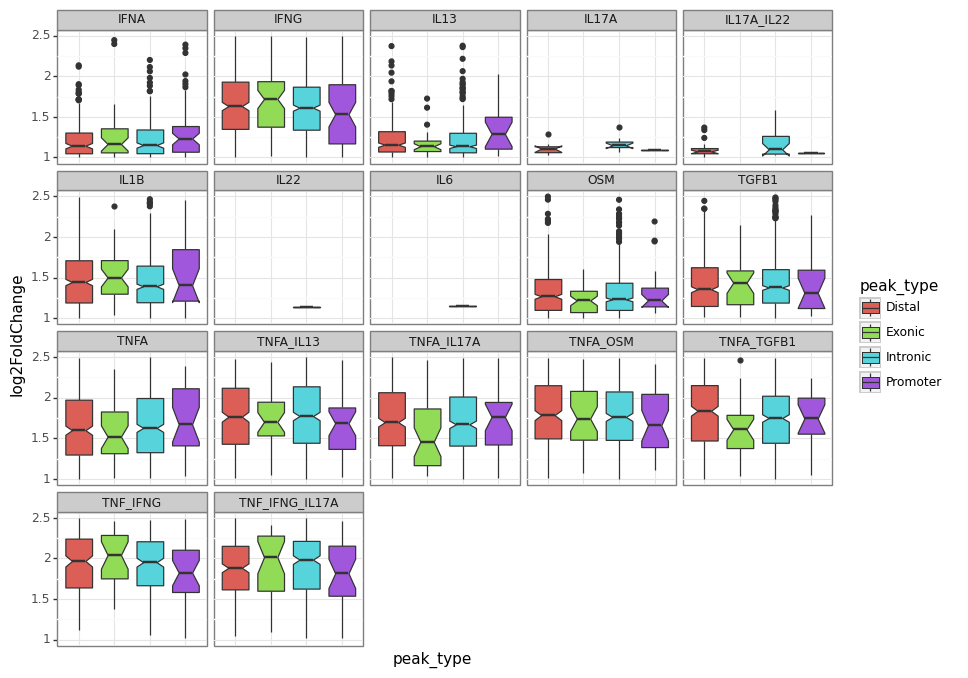

In [23]:
pln.options.figure_size = (10, 8)
print(
    ggplot(df1.groupby(['stim', 'peak_type']).head(1000), aes(y='log2FoldChange', x='peak_type')) +
    pln.facet_wrap('~stim') +
    pln.geom_boxplot(aes(fill='peak_type'), notch=True) +
    pln.ylim(1, 2.5) +
    pln.theme_bw() +
    pln.theme(axis_ticks_major_x=pln.element_blank(), axis_text_x=pln.element_blank())
)

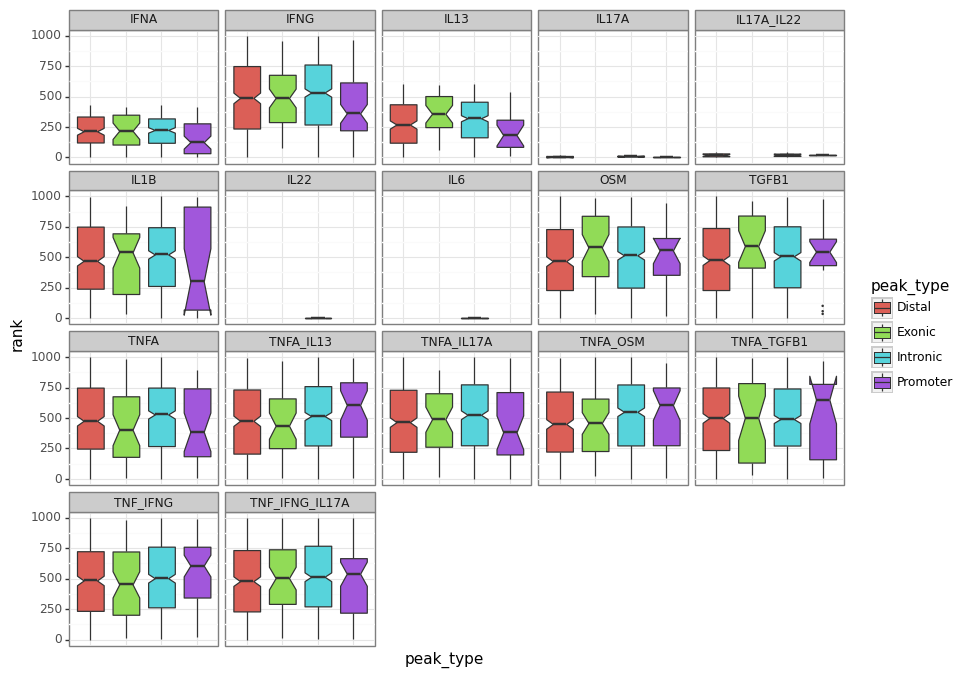

In [24]:
pln.options.figure_size = (10, 8)
print(
    ggplot(df1.groupby(['stim', 'peak_type']).head(1000), aes(y='rank', x='peak_type')) +
    pln.facet_wrap('~stim') +
    pln.geom_boxplot(aes(fill='peak_type'), notch=True, outlier_size=0, outlier_shape=None) +
    pln.theme_bw() +
    pln.theme(axis_ticks_major_x=pln.element_blank(), axis_text_x=pln.element_blank())
)

TODO:
1. split by type of peaks (promoter, distal, exonic, intronic, etc)
2. test number of peaks selected

In [25]:
atac_up_peaks = {}
for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal'):
    atac_up_peaks[pt] = {
        astim.upper(): load_de_peaks(f'bulkATAC_DE/{astim}.{astim}-vs-unstimulated.txt', sep='\t', max_p=0.01, min_lfc=2, peak_types=[pt]) for astim in atac_stimulations
    }

In [26]:
for pt in atac_up_peaks.keys():
    for st, df in atac_up_peaks[pt].items():
        print(f'{pt}, {st}, {len(df)}')

Promoter, IFNA, 53
Promoter, IFNG, 133
Promoter, IL13, 17
Promoter, IL17A, 1
Promoter, IL17A_IL22, 1
Promoter, IL1B, 90
Promoter, IL22, 0
Promoter, IL6, 0
Promoter, OSM, 49
Promoter, TGFB1, 50
Promoter, TNFA_IL13, 149
Promoter, TNFA_IL17A, 234
Promoter, TNFA_OSM, 452
Promoter, TNFA_TGFB1, 269
Promoter, TNFA, 130
Promoter, TNF_IFNG_IL17A, 749
Promoter, TNF_IFNG, 734
Exonic, IFNA, 33
Exonic, IFNG, 164
Exonic, IL13, 31
Exonic, IL17A, 0
Exonic, IL17A_IL22, 0
Exonic, IL1B, 128
Exonic, IL22, 0
Exonic, IL6, 0
Exonic, OSM, 90
Exonic, TGFB1, 70
Exonic, TNFA_IL13, 256
Exonic, TNFA_IL17A, 300
Exonic, TNFA_OSM, 587
Exonic, TNFA_TGFB1, 429
Exonic, TNFA, 224
Exonic, TNF_IFNG_IL17A, 949
Exonic, TNF_IFNG, 989
Intronic, IFNA, 199
Intronic, IFNG, 1000
Intronic, IL13, 339
Intronic, IL17A, 10
Intronic, IL17A_IL22, 20
Intronic, IL1B, 1000
Intronic, IL22, 1
Intronic, IL6, 1
Intronic, OSM, 1000
Intronic, TGFB1, 1000
Intronic, TNFA_IL13, 1000
Intronic, TNFA_IL17A, 1000
Intronic, TNFA_OSM, 1000
Intronic, TNFA_

In [27]:
#atacP_ad = sc.read('scATAC_PeakMatrix.processed.cellxgene.h5ad', backed='r')
#atacP_ad = sc.read('../fibroblast_reanalysis/data/scATAC_PeakMatrix_fibro.processed.h5ad', backed='r')
atacP_ad = sc.read('../fibroblast_reanalysis/data/scATAC_PeakMatrix_fibro.processed.h5ad')

In [28]:
atacP_ad

AnnData object with n_obs × n_vars = 56689 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 

In [29]:
atacP_ad.var_names[0:10]

Index(['chr1:794840-795340,FAM87B,Distal', 'chr1:807550-808050,FAM87B,Distal',
       'chr1:811011-811511,FAM87B,Distal',
       'chr1:817090-817590,FAM87B,Promoter',
       'chr1:817824-818324,FAM87B,Exonic', 'chr1:818479-818979,FAM87B,Exonic',
       'chr1:820945-821445,FAM87B,Distal',
       'chr1:826556-827056,LINC00115,Exonic',
       'chr1:827241-827741,LINC00115,Promoter',
       'chr1:830679-831179,LINC00115,Intronic'],
      dtype='object', name='index')

In [30]:
pd.Series(atacP_ad.var_names).str.rpartition(',')[2].value_counts()

2
Intronic    210466
Distal      140460
Promoter     29109
Exonic       27348
Name: count, dtype: int64

In [31]:
gc.collect()

74536

# Process

## RNA gene scoring

In [32]:
rna_ad

AnnData object with n_obs × n_vars = 26727 × 17592
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc'
    obsm: 'X_pca', 'X_umap', 'X_umap_bk'

In [33]:
for rstim, rup in rna_up_genes.items():
    g = rup.index.to_list()
    sc.tl.score_genes(rna_ad, g, ctrl_size=len(g), score_name=f'{rstim}_upreg')

In [34]:
for rstim in rna_up_genes.keys():
    x = rna_ad.obs[f'{rstim}_upreg'].values
    rna_ad.obs[f'{rstim}_upreg_scaled'] = (x-x.mean()) / np.std(x)

In [35]:
#sk.plot_embedding(rna_ad, groupby='annot1', basis='umap_bk');

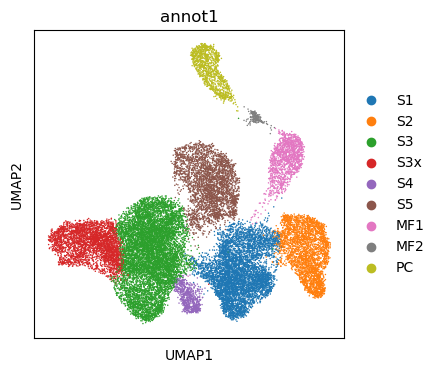

In [36]:
sc.pl.umap(rna_ad, color='annot1')

In [37]:
# rna_up_genes_show = rna_up_genes.copy()
# del rna_up_genes_show['IL6']
# #del rna_up_genes_show['IL22']

# sc.set_figure_params(dpi_save=300)

# sk.set_figsize((3, 3))
# sc.pl.embedding(
#     rna_ad,
#     basis='X_umap',
#     color=['annot1'] + [f'{rstim}_upreg' for rstim in rna_up_genes_show.keys()],
#     ncols=5,
#     #cmap='viridis',
#     cmap='RdBu_r',
#     title=['Cell type'] + [f'{rstim}_upreg, n={rna_up_genes[rstim].shape[0]}' for rstim in rna_up_genes_show.keys()],
#     #vmin=-0.5, vmax=1,
#     #vcenter=0,
#     #save="_bulkDE_signature_projection_scaled.pdf"
# )

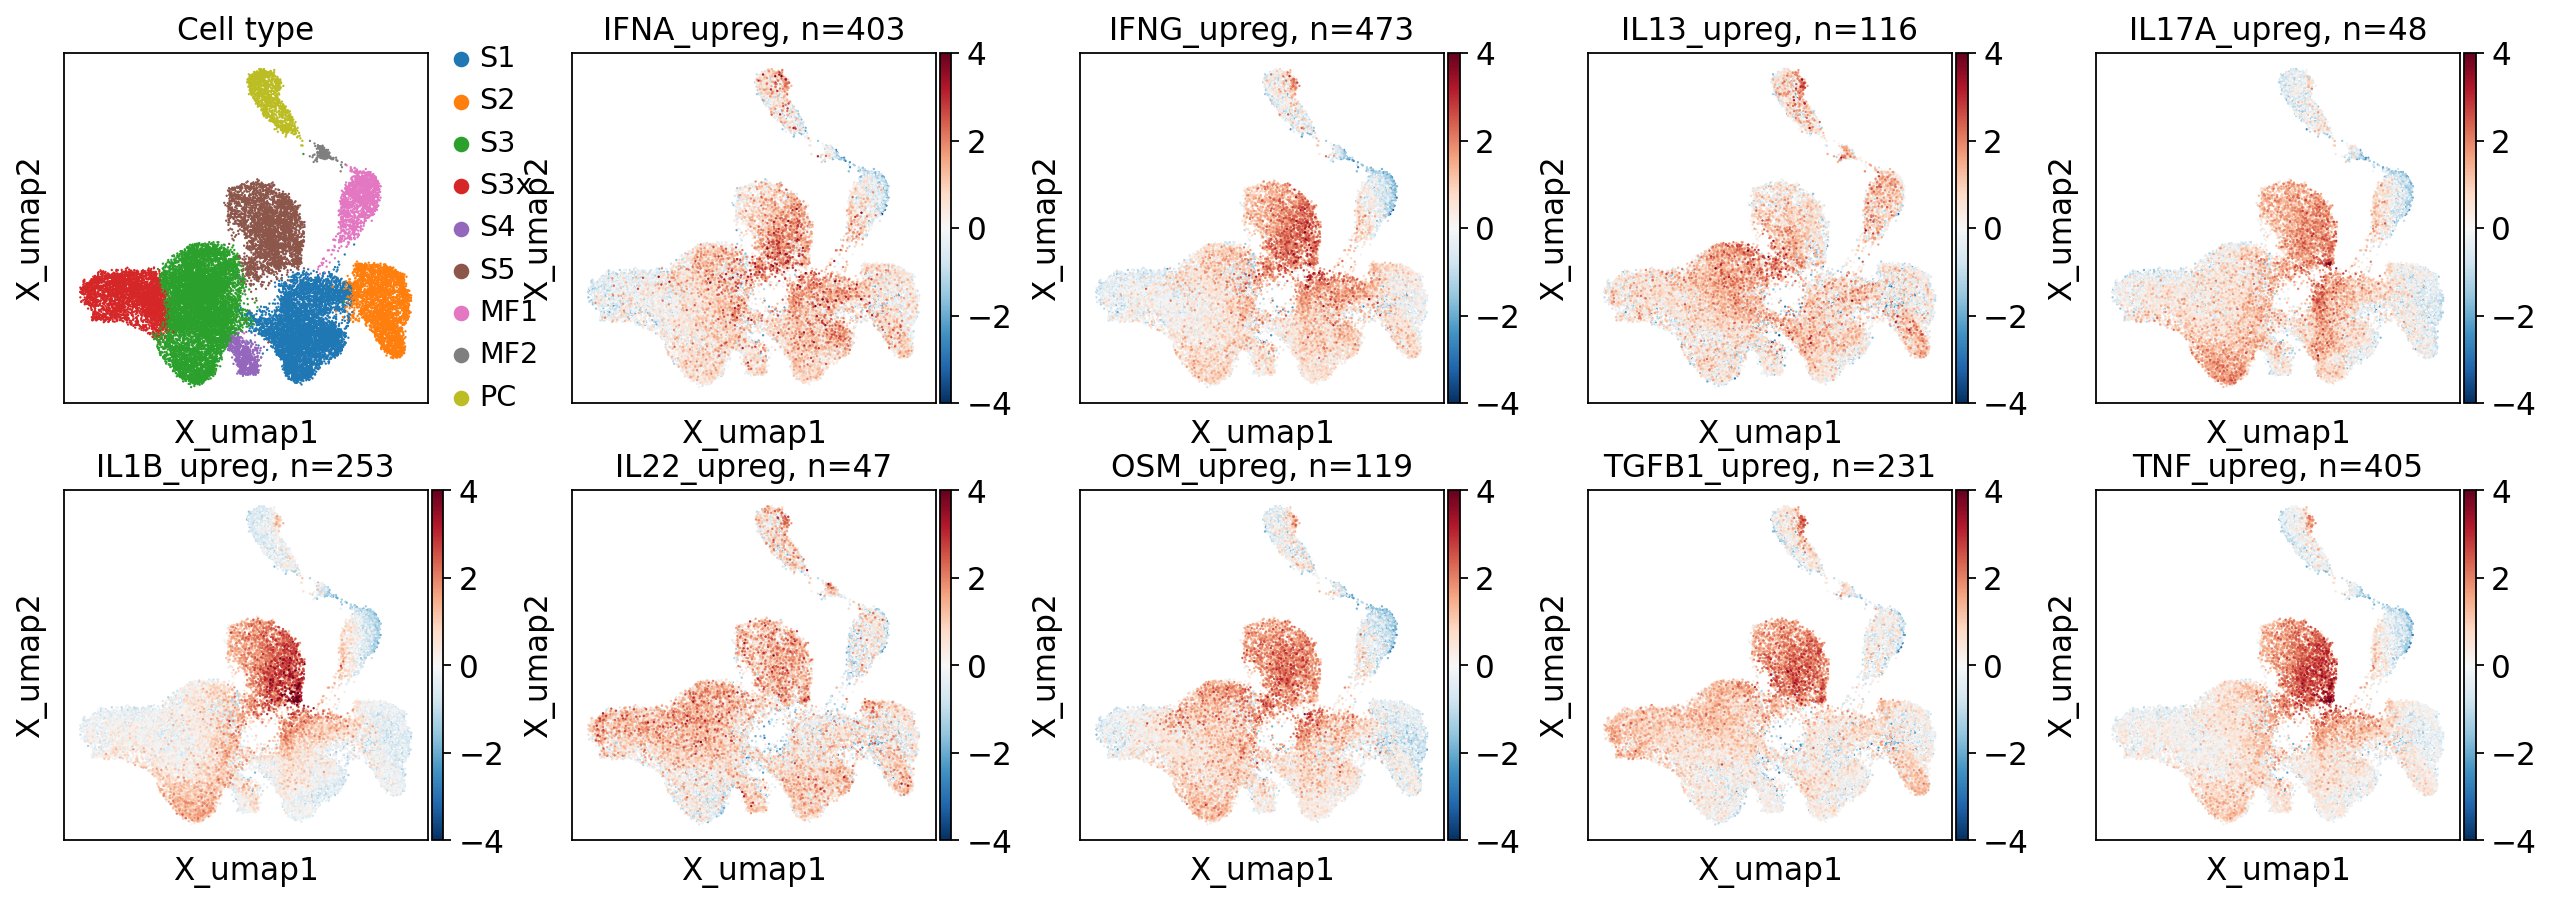

In [38]:
rna_up_genes_show = rna_up_genes.copy()
del rna_up_genes_show['IL6']
#del rna_up_genes_show['IL22']

sc.set_figure_params(dpi_save=300)

sk.set_figsize((3, 3))
sc.pl.embedding(
    rna_ad,
    basis='X_umap',
    color=['annot1'] + [f'{rstim}_upreg_scaled' for rstim in rna_up_genes_show.keys()],
    ncols=5,
    #cmap='viridis',
    cmap='RdBu_r',
    title=['Cell type'] + [f'{rstim}_upreg, n={rna_up_genes[rstim].shape[0]}' for rstim in rna_up_genes_show.keys()],
    vmin=-4, vmax=4,
    #vcenter=0,
    save="_bulkDE_signature_projection_scaled_v2.pdf"
)

In [39]:
import seaborn as sns

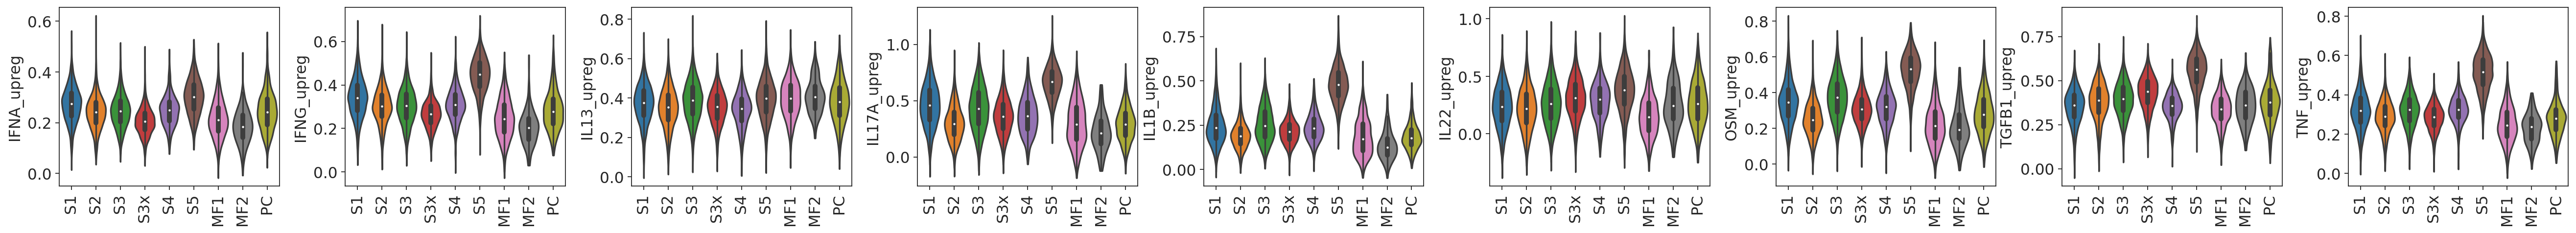

In [40]:
sk.set_figsize((4, 3))

sns.set_style("ticks")  # to prevent gridlines
sc.pl.violin(
    rna_ad,
    groupby='annot1',
    keys=[f'{rstim}_upreg' for rstim in rna_up_genes.keys() if rstim not in ('IL6')],
    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_bulkDE_signature_projection.pdf",
    grid=False
)


In [41]:
# save bulkRNA DE scoring
rna_ad.obs[[f'{rstim}_upreg' for rstim in rna_up_genes.keys()]].to_csv('scRNA_batch1_2.bulkDE_scoring.csv.gz')

In [42]:
rna_upreg_df = pd.DataFrame(
    npg.aggregate(rna_ad.obs.annot1.cat.codes, rna_ad.obs[[f'{rstim}_upreg_scaled' for rstim in rna_up_genes.keys()]].values, func='mean', axis=0),
    index=rna_ad.obs.annot1.cat.categories, columns=list(rna_up_genes.keys())
)

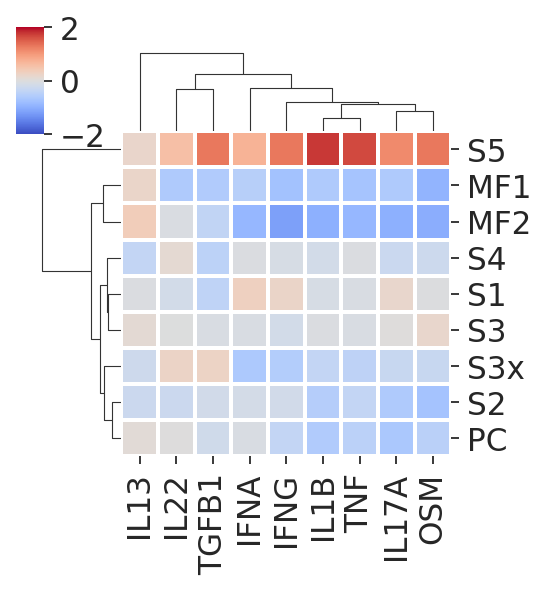

In [43]:
cg = sn.clustermap(
    #rna_upreg_df[[stim for stim in rna_upreg_df.columns if stim not in ('IL6', 'IL22')]],
    rna_upreg_df[[stim for stim in rna_upreg_df.columns if stim not in ('IL6')]],

    cmap='coolwarm',
    figsize=(3.5, 3.7),
    linewidths=1,  # separating lines
    vmin=-2,
    vmax=2);
# cg.ax_row_dendrogram.set_visible(False);
# cg.ax_col_dendrogram.set_visible(False);
#cg.fig.suptitle('Up-regulated genes')
cg.savefig("figures/heatmap_bulkDE_signature_projection_scaled.pdf")
plt.show()

In [44]:
# sk.set_figsize((6, 3))
# for rstim in rna_up_genes.keys():
#     sc.pl.violin(rna_ad, [f'{rstim}_upreg'], groupby='annot1', stripplot=False, rotation=90)

## ATAC gene scoring

In [45]:
# Evaluate scores for upregulated peaks
sc.settings.verbosity = 1
for astim, aup in atac_up_all_peaks.items():
    g = aup.index.to_list()
    sc.tl.score_genes(atacP_ad, g, ctrl_size=len(g), score_name=f'{astim}_upreg')

In [46]:
# Standardize scores
for astim in atac_up_all_peaks.keys():
    x = atacP_ad.obs[f'{astim}_upreg'].values
    atacP_ad.obs[f'{astim}_upreg_scaled'] = (x-x.mean()) / np.std(x)

In [47]:
# Calculate split scores by peak type
sc.settings.verbosity = 1
for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal'):
    for astim, aup in atac_up_peaks[pt].items():
        g = aup.index.to_list()
        print(len(g))
        if len(g) < 2:  # require at least 2 genes in upregulated set
            continue  # skip
        
        # score peak set
        sc.tl.score_genes(atacP_ad, g, ctrl_size=len(g), score_name=f'{astim}_upreg_{pt}')
        
        x = atacP_ad.obs[f'{astim}_upreg_{pt}'].values  # get vector of scores
        
        # standardize scores (for visualization purposes)
        atacP_ad.obs[f'{astim}_upreg_{pt}_scaled'] = (x-x.mean()) / np.std(x)

53
133
17
1
1
90
0
0
49
50
149
234
452
269
130
749
734
33
164
31
0
0
128
0
0
90
70
256
300
587
429
224
949
989
199
1000
339
10
20
1000
1
1
1000
1000
1000
1000
1000
1000
1000
1000
1000
145
998
218
8
22
1000
0
0
753
976
1000
1000
1000
1000
1000
1000
1000


In [48]:
atac_up_all_peaks.keys()

dict_keys(['IFNA', 'IFNG', 'IL13', 'IL17A', 'IL17A_IL22', 'IL1B', 'IL22', 'IL6', 'OSM', 'TGFB1', 'TNFA_IL13', 'TNFA_IL17A', 'TNFA_OSM', 'TNFA_TGFB1', 'TNFA', 'TNF_IFNG_IL17A', 'TNF_IFNG'])

In [49]:
atac_up_all_peaks['IFNA']

baseMean  log2FoldChange  \
chr12:112978182-112978682,OAS2,Promoter   5613.686509        3.201410   
chr19:17405416-17405916,BST2,Promoter     3253.271244        3.549434   
chr8:143026243-143026743,LY6E-DT,Distal   6298.065003        2.119271   
chr10:89310018-89310518,IFIT2,Intronic    1901.074831        3.711045   
chr21:41425999-41426499,MX1,Exonic        3732.942210        2.446378   
...                                               ...             ...   
chr4:70735763-70736263,RUFY3,Intronic      552.186491        1.002141   
chr2:33419752-33420252,RASGRP3,Distal      477.410355        1.030663   
chr15:44720858-44721358,TRIM69,Distal      744.334915        1.000755   
chr10:28178216-28178716,MIR8086,Intronic   577.669082        1.008341   
chr5:177300186-177300686,PRELID1,Distal   2899.725650        1.030229   

                                             lfcSE       stat        pvalue  \
chr12:112978182-112978682,OAS2,Promoter   0.167094  19.159347  8.088135e-82   
chr19:17405416-17405916,BST2,Promoter     0.194233  18.274109  1.330462e-74   
chr8:143026243-143026743,LY6E-DT,Distal   0.118489  17.885747  1.522983e-71   
chr10:89310018-89310518,IFIT2,Intronic    0.238221  15.578133  1.025048e-54   
chr21:41425999-41426499,MX1,Exonic        0.172388  14.191151  1.039390e-45   
...                                            ...        ...           ...   
chr4:70735763-70736263,RUFY3,Intronic     0.271770   3.687467  2.264975e-04   
chr2:33419752-33420252,RASGRP3,Distal     0.279645   3.685618  2.281482e-04   
chr15:44720858-44721358,TRIM69,Distal     0.273334   3.661285  2.509531e-04   
chr10:28178216-28178716,MIR8086,Intronic  0.276348   3.648816  2.634516e-04   
chr5:177300186-177300686,PRELID1,Distal   0.282506   3.646752  2.655755e-04   

                                                  padj  stim  rank peak_type  
chr12:112978182-112978682,OAS2,Promoter   1.187913e-76  IFNA     0  Promoter  
chr19:17405416-17405916,BST2,Promoter     9.770311e-70  IFNA     1  Promoter  
chr8:143026243-143026743,LY6E-DT,Distal   7.456067e-67  IFNA     2    Distal  
chr10:89310018-89310518,IFIT2,Intronic    3.763744e-50  IFNA     3  Intronic  
chr21:41425999-41426499,MX1,Exonic        3.053124e-41  IFNA     4    Exonic  
...                                                ...   ...   ...       ...  
chr4:70735763-70736263,RUFY3,Intronic     7.851291e-03  IFNA   425  Intronic  
chr2:33419752-33420252,RASGRP3,Distal     7.897769e-03  IFNA   426    Distal  
chr15:44720858-44721358,TRIM69,Distal     8.470659e-03  IFNA   427    Distal  
chr10:28178216-28178716,MIR8086,Intronic  8.777995e-03  IFNA   428  Intronic  
chr5:177300186-177300686,PRELID1,Distal   8.838737e-03  IFNA   429    Distal  

[430 rows x 9 columns]

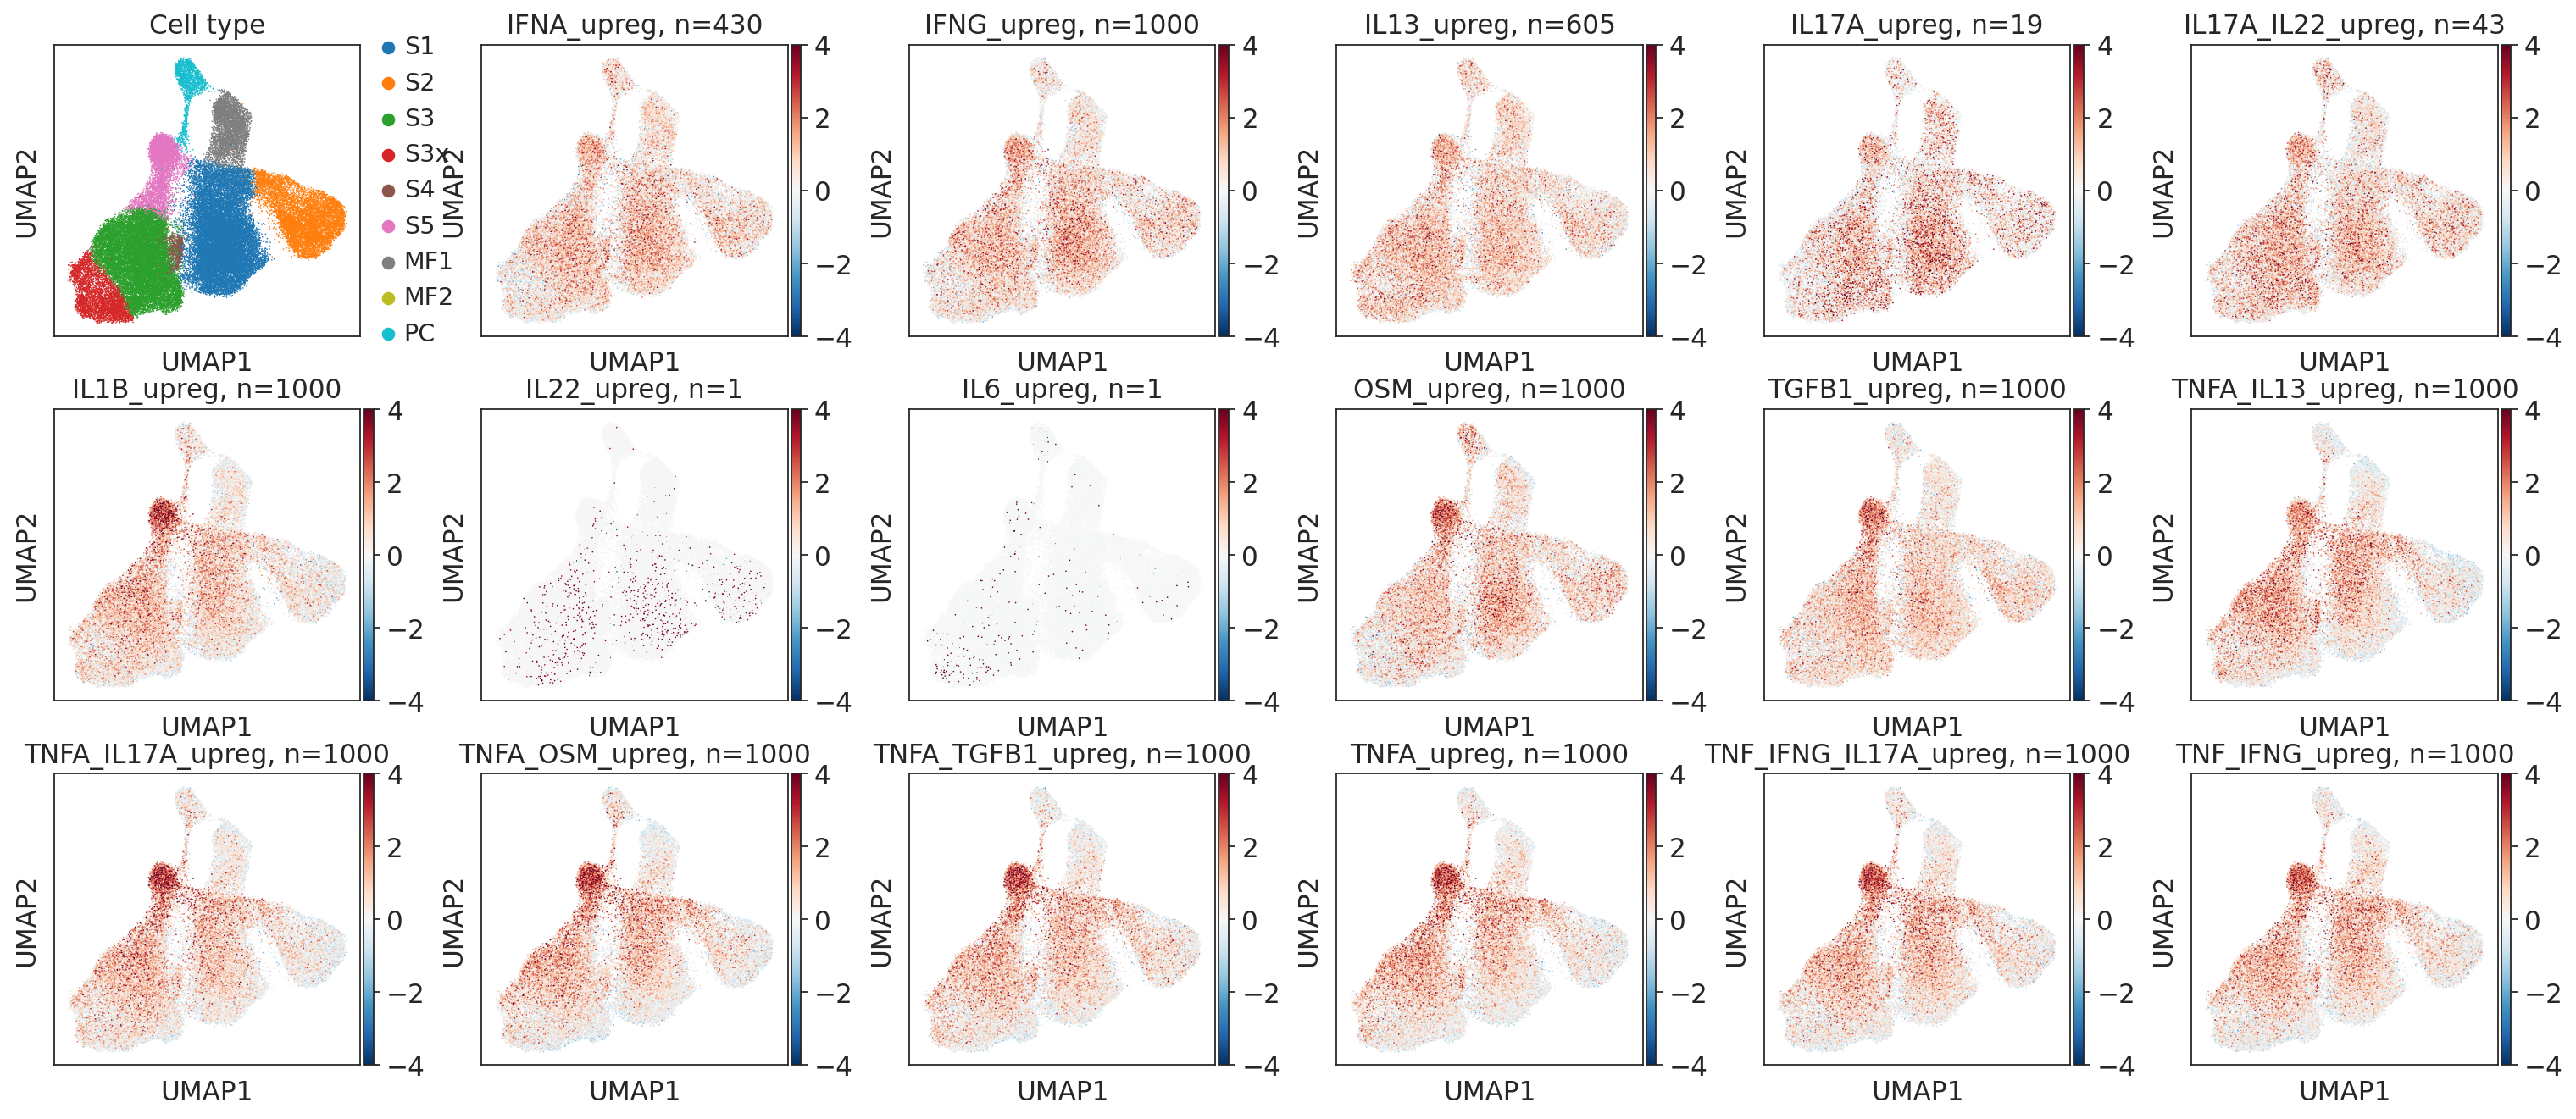

In [50]:
sk.set_figsize((3, 3))
sc.pl.embedding(atacP_ad,
                basis='umap',
                color=['annot1'] + [f'{astim}_upreg_scaled' for astim in atac_up_all_peaks.keys()],
                title=['Cell type'] + [f'{astim}_upreg, n={atac_up_all_peaks[astim].shape[0]}' for astim in atac_up_all_peaks.keys()],
                ncols=6,
                vmin=-4, vmax=4,
                cmap='RdBu_r',
                save="_ATAC_bulkDE_signature_projection_scaled.pdf"
)

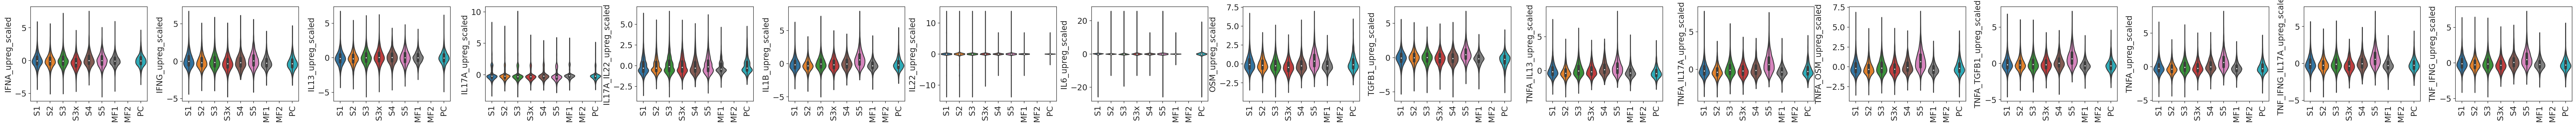

In [51]:
sk.set_figsize((4, 3))

sns.set_style("ticks")  # to prevent gridlines
sc.pl.violin(
    atacP_ad,
    groupby='annot1',
    keys=[f'{astim}_upreg_scaled' for astim in atac_up_all_peaks.keys() if astim not in []],
    #jitter=False,
    stripplot=False,
    inner='box',
    #figsize=(20, 4),
    rotation=90,
    save="_ATAC_bulkDE_signature_projection.pdf",
    grid=False
)

save bulkATAC DE scoring

In [52]:
# All score keys to save
score_keys = [f'{astim}_upreg' for astim in atac_up_all_peaks.keys()] + [f'{astim}_upreg_{pt}' for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal') for astim in atac_up_peaks[pt].keys()]

# filter for existing keys only
score_keys = atacP_ad.obs.columns.intersection(score_keys)

# Write so file
atacP_ad.obs[score_keys].to_csv('scATAC_PeakMatrix.bulkDE_scoring.csv.gz')

In [53]:
atac_scoring = pd.read_csv('scATAC_PeakMatrix.bulkDE_scoring.csv.gz', index_col=0)

In [54]:
atac_scoring

IFNA_upreg  IFNG_upreg  IL13_upreg  IL17A_upreg  \
index                                                                     
A11#GGACACCCAAGCCTTA-1    0.011957    0.045551    0.014595     0.056391   
A11#AACTGGTAGCGCCTAC-1   -0.002643    0.027154    0.005285    -0.112782   
A11#AACGAGGGTTTGCCAA-1    0.024286    0.021600    0.002934     0.184211   
A11#GCAACCGGTGGTACTT-1   -0.006242    0.009751    0.025993    -0.075188   
A11#TTACGTTAGCATACCT-1   -0.009242    0.014951    0.027234     0.139098   
...                            ...         ...         ...          ...   
A08#AGGCGAAAGCAGAGCT-1   -0.001071    0.001318    0.004123     0.000000   
A08#TAGCCCTGTTTGTCTT-1    0.000673    0.003527   -0.005932     0.000000   
A08#AACGGGACATCATCGA-1    0.003483   -0.000351   -0.000629    -0.007519   
A08#TTAGGTGCATCGGCCA-1   -0.000683   -0.003515    0.006742     0.000000   
A08#CCGTGAGTCGAACACT-1    0.004647   -0.004805   -0.003038     0.000000   

                        IL17A_IL22_upreg  IL1B_upreg  IL22_upreg  IL6_upreg  \
index                                                                         
A11#GGACACCCAAGCCTTA-1          0.111628    0.073728         0.0        0.0   
A11#AACTGGTAGCGCCTAC-1         -0.095349    0.021488         0.0        0.0   
A11#AACGAGGGTTTGCCAA-1          0.283721   -0.005399         0.0        1.0   
A11#GCAACCGGTGGTACTT-1          0.041860    0.048795         0.0        0.0   
A11#TTACGTTAGCATACCT-1         -0.013953    0.014205         0.0        0.0   
...                                  ...         ...         ...        ...   
A08#AGGCGAAAGCAGAGCT-1         -0.013953    0.000236         0.0        0.0   
A08#TAGCCCTGTTTGTCTT-1         -0.008140    0.000528         0.0        0.0   
A08#AACGGGACATCATCGA-1         -0.006977    0.002651         0.0        0.0   
A08#TTAGGTGCATCGGCCA-1         -0.009302   -0.000514         0.0        0.0   
A08#CCGTGAGTCGAACACT-1         -0.008140    0.000197         0.0        0.0   

                        OSM_upreg  TGFB1_upreg  ...  IL1B_upreg_Distal  \
index                                           ...                      
A11#GGACACCCAAGCCTTA-1   0.043636     0.007375  ...           0.057740   
A11#AACTGGTAGCGCCTAC-1   0.044380    -0.012578  ...           0.009297   
A11#AACGAGGGTTTGCCAA-1   0.064620    -0.007548  ...           0.048618   
A11#GCAACCGGTGGTACTT-1   0.041775    -0.007103  ...           0.044728   
A11#TTACGTTAGCATACCT-1   0.003810     0.009765  ...           0.002012   
...                           ...          ...  ...                ...   
A08#AGGCGAAAGCAGAGCT-1   0.003238     0.005237  ...          -0.002723   
A08#TAGCCCTGTTTGTCTT-1   0.000530    -0.003471  ...          -0.001473   
A08#AACGGGACATCATCGA-1   0.006654    -0.000348  ...           0.004650   
A08#TTAGGTGCATCGGCCA-1   0.004489     0.004487  ...          -0.004514   
A08#CCGTGAGTCGAACACT-1   0.001199     0.000197  ...           0.000196   

                        OSM_upreg_Distal  TGFB1_upreg_Distal  \
index                                                          
A11#GGACACCCAAGCCTTA-1          0.030698           -0.005468   
A11#AACTGGTAGCGCCTAC-1          0.042543            0.006797   
A11#AACGAGGGTTTGCCAA-1          0.074137            0.010162   
A11#GCAACCGGTGGTACTT-1          0.022663           -0.001467   
A11#TTACGTTAGCATACCT-1          0.020945           -0.007880   
...                                  ...                 ...   
A08#AGGCGAAAGCAGAGCT-1         -0.003219            0.009547   
A08#TAGCCCTGTTTGTCTT-1         -0.000452           -0.003473   
A08#AACGGGACATCATCGA-1          0.002093            0.004210   
A08#TTAGGTGCATCGGCCA-1          0.003257           -0.005351   
A08#CCGTGAGTCGAACACT-1          0.004419            0.000329   

                        TNFA_IL13_upreg_Distal  TNFA_IL17A_upreg_Distal  \
index                                                                     
A11#GGACACCCAAGCCTTA-1                0.100726                 0.071406   

In [55]:
atacP_ad.obs = pd.concat([atacP_ad.obs, atac_scoring], axis=1)

In [56]:
atacP_ad.obs.columns

Index(['BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags',
       'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio',
       'PromoterRatio', 'ReadsInBlacklist',
       ...
       'IL1B_upreg_Distal', 'OSM_upreg_Distal', 'TGFB1_upreg_Distal',
       'TNFA_IL13_upreg_Distal', 'TNFA_IL17A_upreg_Distal',
       'TNFA_OSM_upreg_Distal', 'TNFA_TGFB1_upreg_Distal', 'TNFA_upreg_Distal',
       'TNF_IFNG_IL17A_upreg_Distal', 'TNF_IFNG_upreg_Distal'],
      dtype='object', length=291)

In [57]:
atac_upreg_df = pd.DataFrame(
    npg.aggregate(atacP_ad.obs.annot1.cat.codes, atacP_ad.obs[[f'{astim}_upreg_scaled' for astim in atac_up_all_peaks.keys()]].values, func='mean', axis=0),
    index=atacP_ad.obs.annot1.cat.categories, columns=list(atac_up_all_peaks.keys())
)

In [152]:
#atac_up_peaks

In [156]:
atac_upreg_dfs = {}
for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal'):
    score_keys = [f'{astim}_upreg_{pt}_scaled' for astim in atac_up_peaks[pt].keys()]
    score_keys = atacP_ad.obs.columns.intersection(score_keys)  # include only keys that have been computed
    
    atac_upreg_dfs[pt] = pd.DataFrame(
        npg.aggregate(atacP_ad.obs.annot1.cat.codes, atacP_ad.obs[score_keys].values, func='mean', axis=0),
        index=atacP_ad.obs.annot1.cat.categories,
        columns=list(score_keys)
    ).fillna(0)

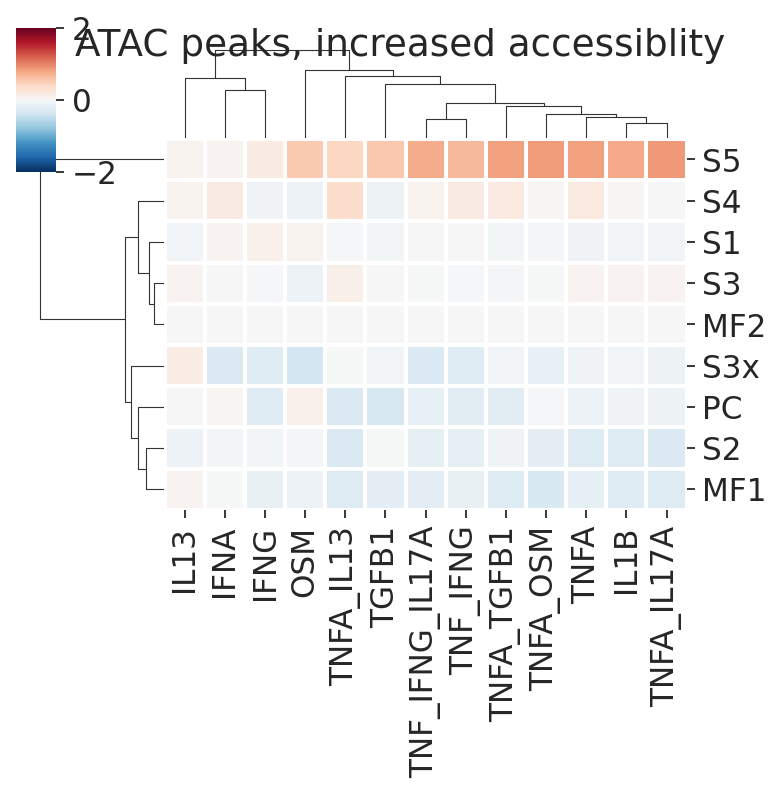

In [157]:
cg = sn.clustermap(
    atac_upreg_df[[stim for stim in atac_upreg_df.columns if stim not in ('IL6', 'IL22', 'IL17A', 'IL17A_IL22')]],
    cmap='RdBu_r',
    figsize=(5, 5), linewidths=1,
    vmin=-2, vmax=2)
cg.fig.suptitle('ATAC peaks, increased accessiblity')
# cg.ax_row_dendrogram.set_visible(False);
# cg.ax_col_dendrogram.set_visible(False);
plt.savefig("figures/heatmap_ATAC_bulkDE_signature_projection_scaled.pdf")
plt.show()


In [158]:
atac_upreg_df.columns

Index(['IFNA', 'IFNG', 'IL13', 'IL17A', 'IL17A_IL22', 'IL1B', 'IL22', 'IL6',
       'OSM', 'TGFB1', 'TNFA_IL13', 'TNFA_IL17A', 'TNFA_OSM', 'TNFA_TGFB1',
       'TNFA', 'TNF_IFNG_IL17A', 'TNF_IFNG'],
      dtype='object')

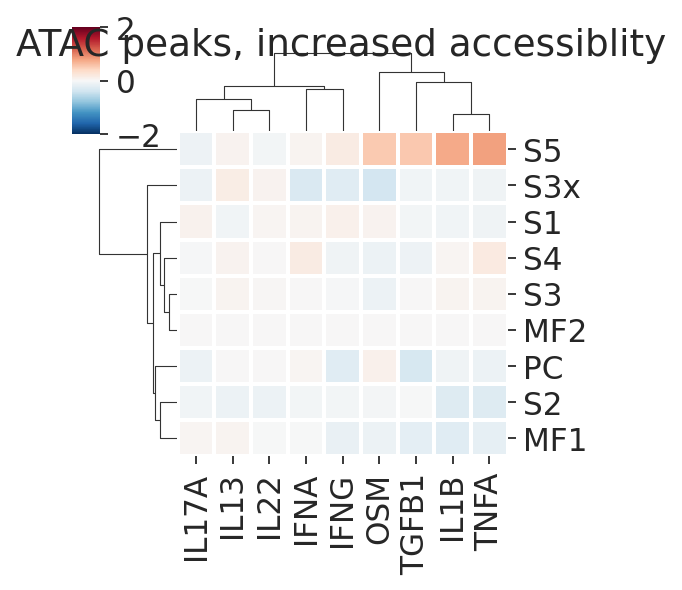

In [175]:
double_stim = ('IL17A_IL22', 'TNFA_IL13', 'TNFA_OSM', 'TNFA_TGFB1', 'TNF_IFNG_IL17A', 'TNF_IFNG', 'TNFA_IL17A', 'IL6')

cg = sn.clustermap(
    atac_upreg_df[[stim for stim in atac_upreg_df.columns if stim not in double_stim]],
    cmap='RdBu_r',
    figsize=(3.5, 3.7), linewidths=1,
    vmin=-2, vmax=2)
cg.fig.suptitle('ATAC peaks, increased accessiblity')
# cg.ax_row_dendrogram.set_visible(False);
# cg.ax_col_dendrogram.set_visible(False);
plt.savefig("figures/heatmap_ATAC_bulkDE_signature_projection_scaled_single.pdf")
plt.show()

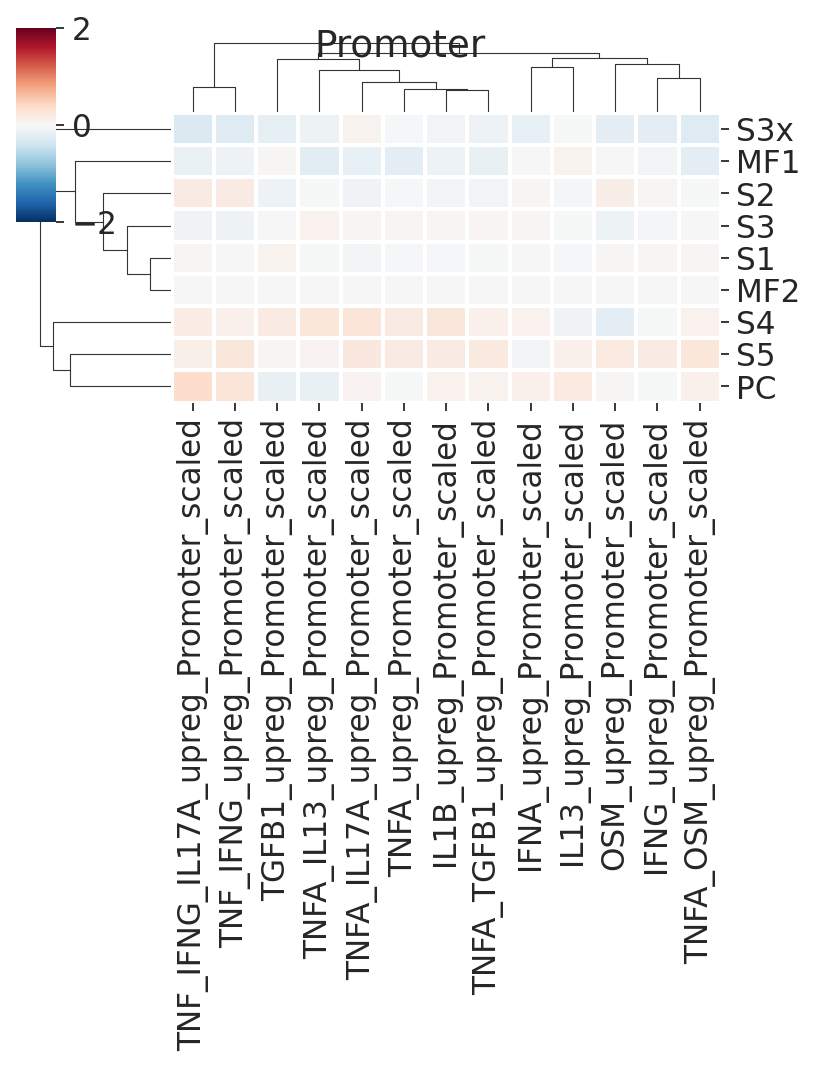

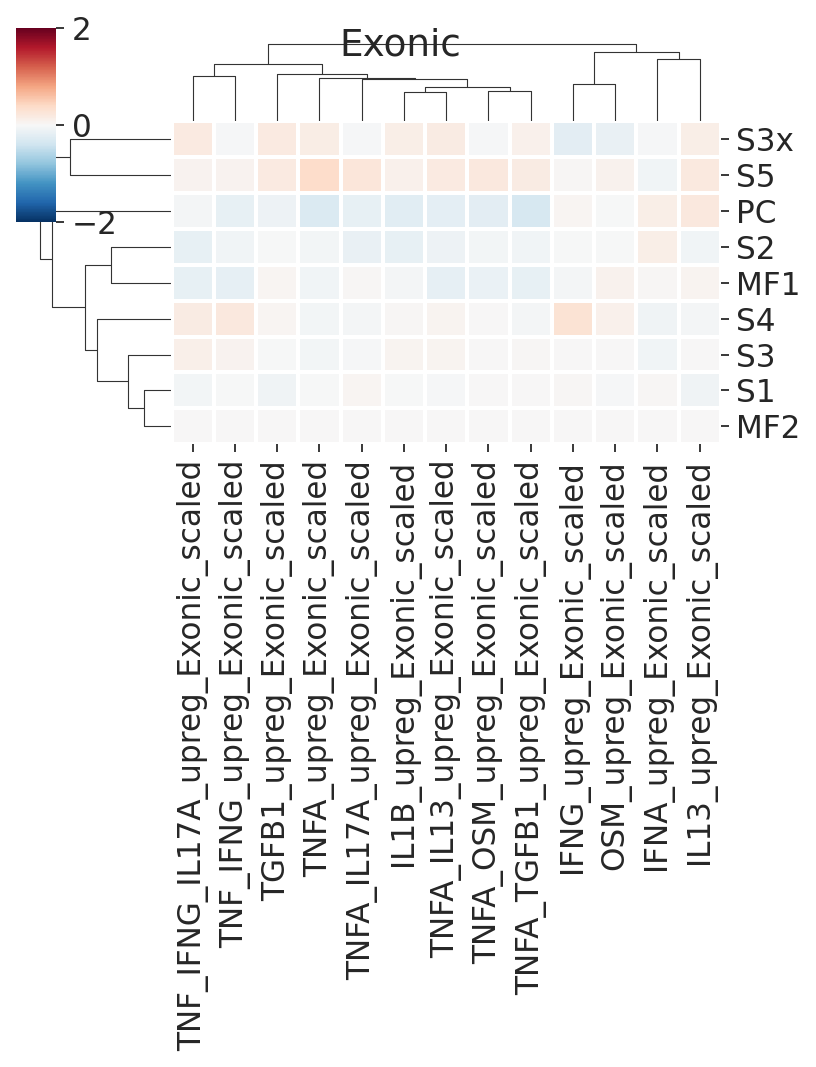

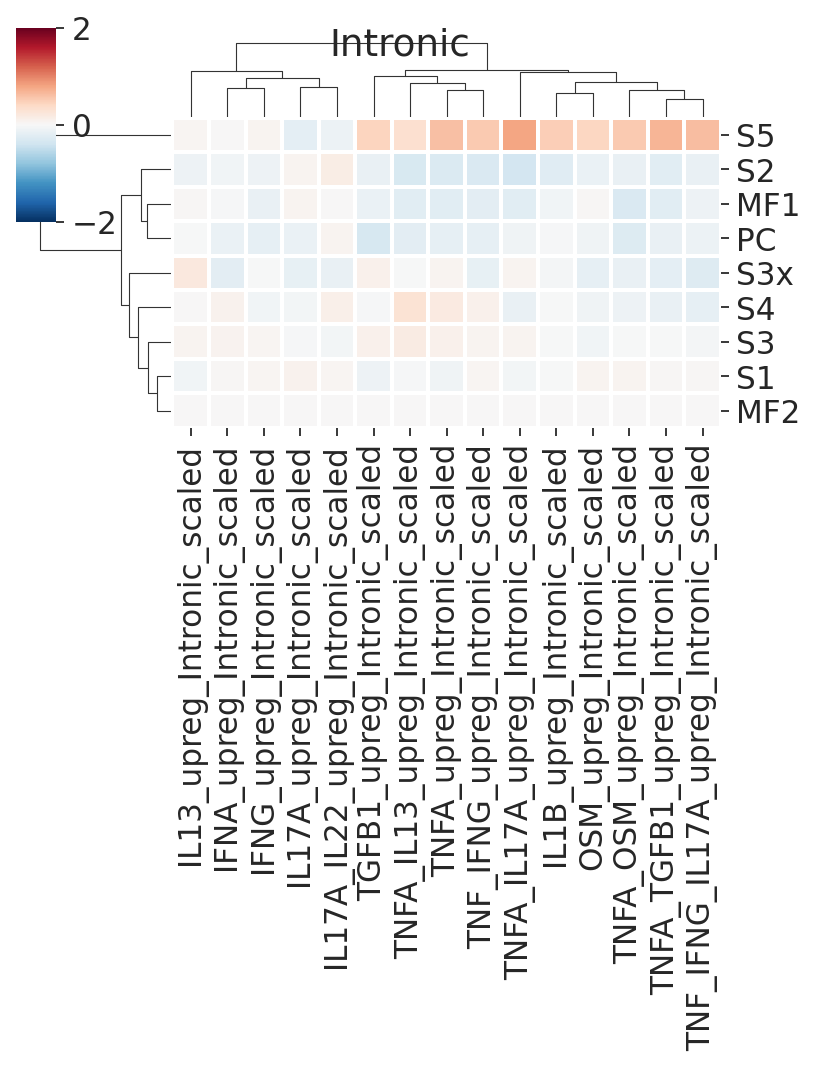

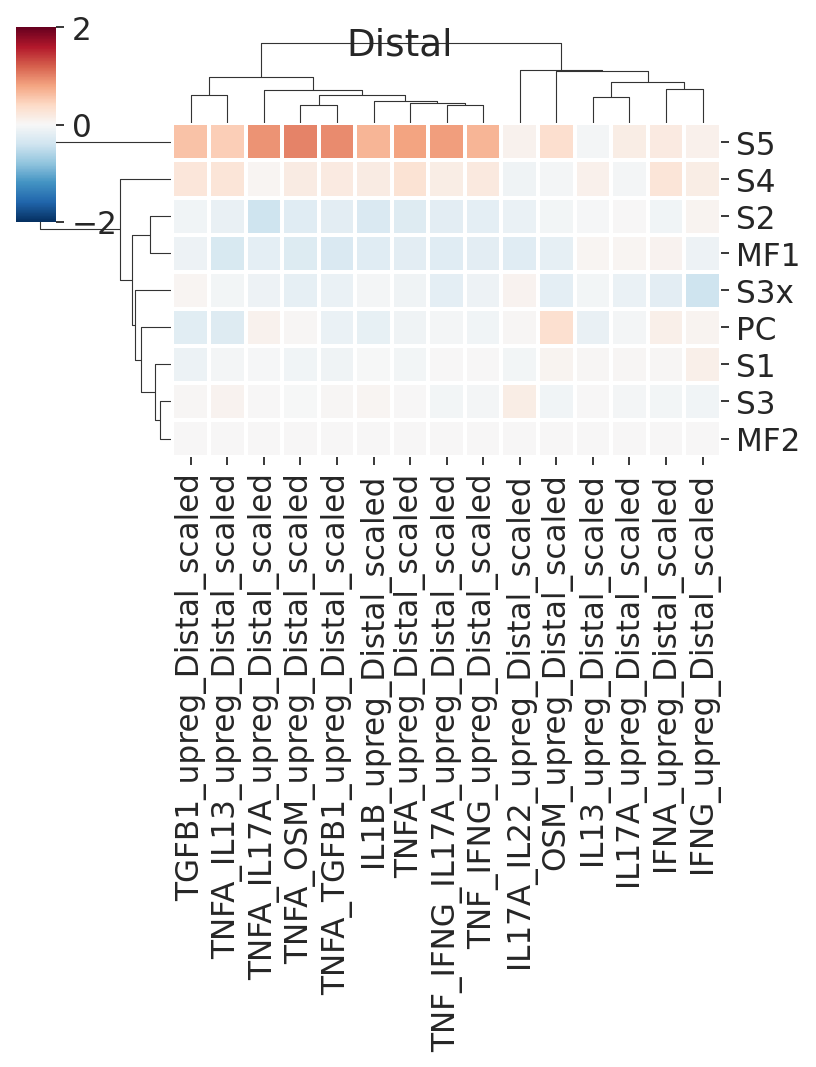

In [160]:
for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal'):
    g = sn.clustermap(
        atac_upreg_dfs[pt][[stim for stim in atac_upreg_dfs[pt].columns if stim not in ('IL6', 'IL22', 'IL17A', 'IL17A_IL22')]],
        cmap='RdBu_r',
        figsize=(5, 6.75),
        linewidths=1.0,
        xticklabels=True,  # force show all 
        vmin=-2, vmax=2
    )
    
    # Specify axis rotation
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    # title
    g.fig.suptitle(pt)
    
    plt.savefig("figures/heatmap_ATAC_bulkDE_signature_projection_scaled_" + pt + ".pdf")
# g.ax_row_dendrogram.set_visible(False);
# g.ax_col_dendrogram.set_visible(False);
plt.show()

In [161]:
#atac_upreg_dfs

In [162]:
atac_upreg_dfs['Promoter'].columns

Index(['IFNA_upreg_Promoter_scaled', 'IFNG_upreg_Promoter_scaled',
       'IL13_upreg_Promoter_scaled', 'IL1B_upreg_Promoter_scaled',
       'OSM_upreg_Promoter_scaled', 'TGFB1_upreg_Promoter_scaled',
       'TNFA_IL13_upreg_Promoter_scaled', 'TNFA_IL17A_upreg_Promoter_scaled',
       'TNFA_OSM_upreg_Promoter_scaled', 'TNFA_TGFB1_upreg_Promoter_scaled',
       'TNFA_upreg_Promoter_scaled', 'TNF_IFNG_IL17A_upreg_Promoter_scaled',
       'TNF_IFNG_upreg_Promoter_scaled'],
      dtype='object')

In [163]:
import re

# Rename columns to just the cytokines, stripping out additional data in columns
for key in atac_upreg_dfs.keys():
    atac_upreg_dfs[key].columns = [re.sub(r'_upreg_.+_scaled', '', s) for s in atac_upreg_dfs[key].columns]
    #print(key)

In [164]:
#atac_upreg_dfs

In [165]:
#atac_upreg_dfs

In [167]:
#atac_upreg_dfs

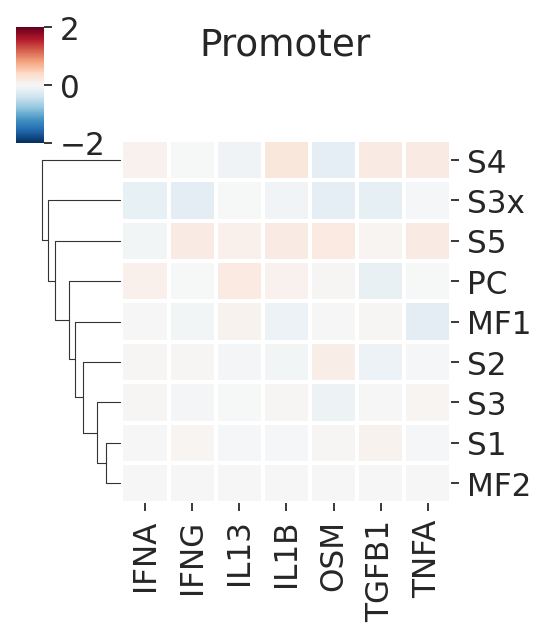

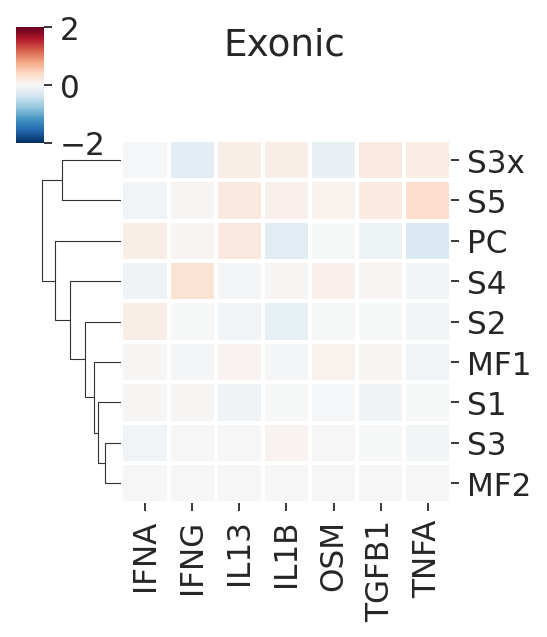

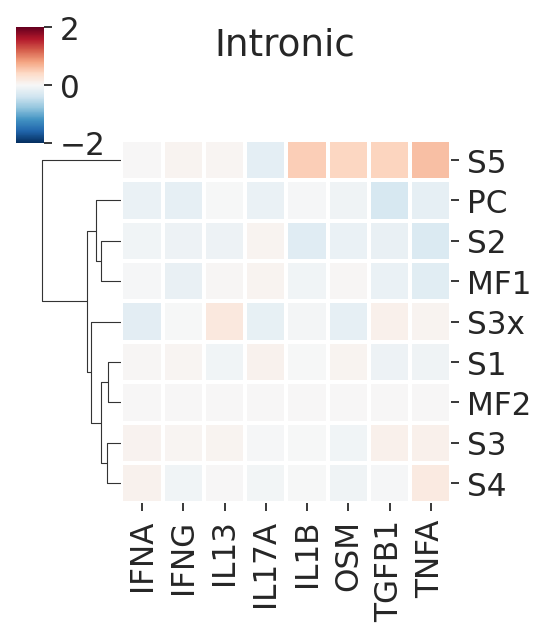

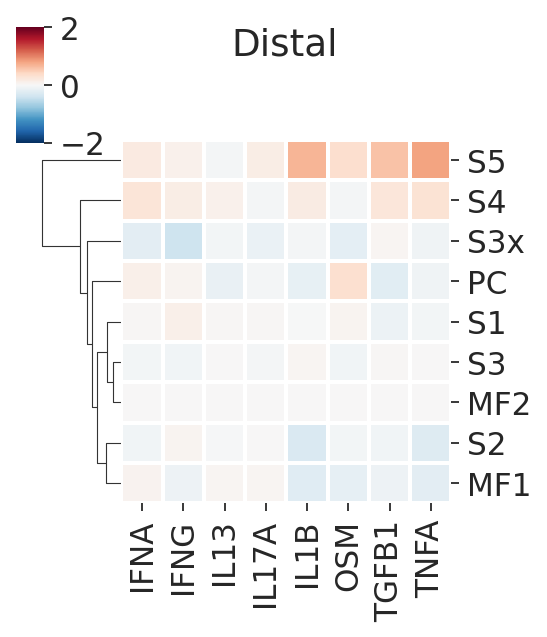

In [168]:
double_stim = ('IL17A_IL22', 'TNFA_IL13', 'TNFA_OSM', 'TNFA_TGFB1', 'TNF_IFNG_IL17A', 'TNF_IFNG', 'TNFA_IL17A')

for pt in ('Promoter', 'Exonic', 'Intronic', 'Distal'):
    g = sn.clustermap(
        atac_upreg_dfs[pt][[stim for stim in atac_upreg_dfs[pt].columns if stim not in double_stim]],
        cmap='RdBu_r',
        figsize=(3.5, 4.0),
        linewidths=1.0,
        xticklabels=True,  # force show all
        col_cluster=False,
        vmin=-2, vmax=2
    )
    
    # Specify axis rotation
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    # title
    g.fig.suptitle(pt)
    
    plt.savefig("figures/heatmap_ATAC_bulkDE_signature_projection_scaled_single_" + pt + ".pdf")
# g.ax_row_dendrogram.set_visible(False);
# g.ax_col_dendrogram.set_visible(False);
plt.show()

In [78]:
# sk.set_figsize((6, 3))
# for astim in atac_up_all_peaks.keys():
#     sc.pl.violin(atacP_ad, [f'{astim}_upreg_scaled'], groupby='annot1', stripplot=False, rotation=90)